In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import IPython

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from pandas.plotting import scatter_matrix

In [2]:
data = pd.read_csv('C:/Users/thebe/DataSets/healthcare_dataset_stroke_data.csv')
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data = data.drop(columns='id')

In [34]:
columns_to_count = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
counts_to_stats = {}
for column in columns_to_count:
    counts_to_stats[column] = data[column].value_counts()

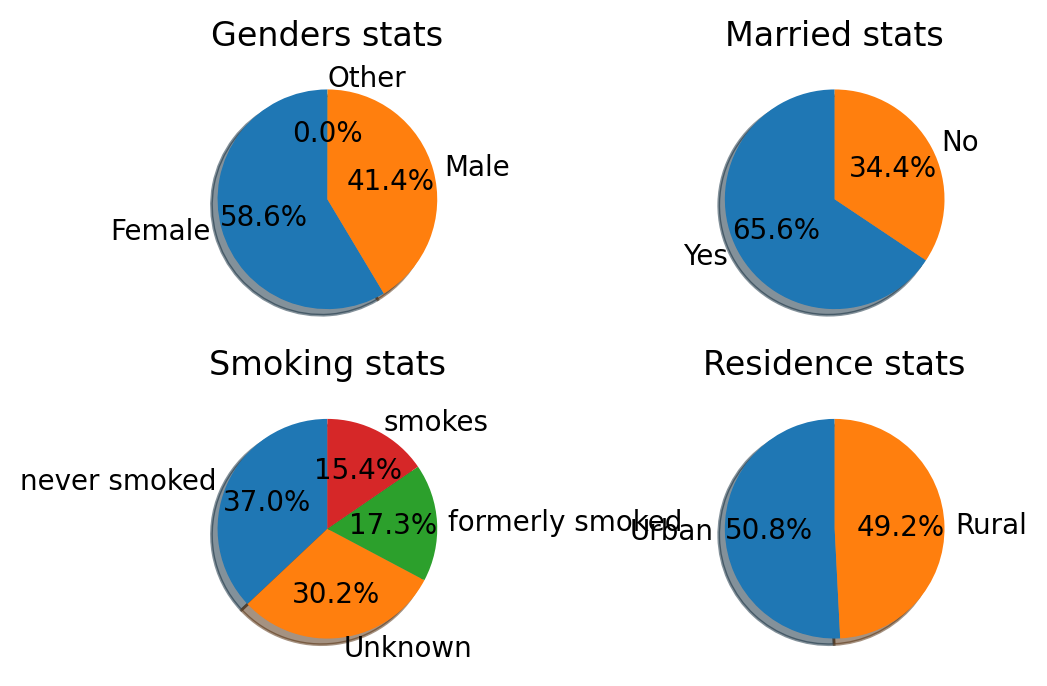

In [35]:
def plot_stats(x, y, column, title, axes):
    axes[x, y].pie(counts_to_stats[column].values, labels=counts_to_stats[column].index.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
    axes[x, y].set_title(title)
    
def plot_single_stats(column, title):
    plt.pie(counts_to_stats[column].values, labels=counts_to_stats[column].index.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title(title)

plt.rcParams['figure.dpi'] = 200
    
fig_stats, axs = plt.subplots(2, 2)
plot_stats(0, 0, 'gender', 'Genders stats', axs)
plot_stats(0, 1, 'ever_married', 'Married stats', axs)
plot_stats(1, 0, 'smoking_status', 'Smoking stats', axs)
plot_stats(1, 1, 'Residence_type', 'Residence stats', axs)
plt.show()

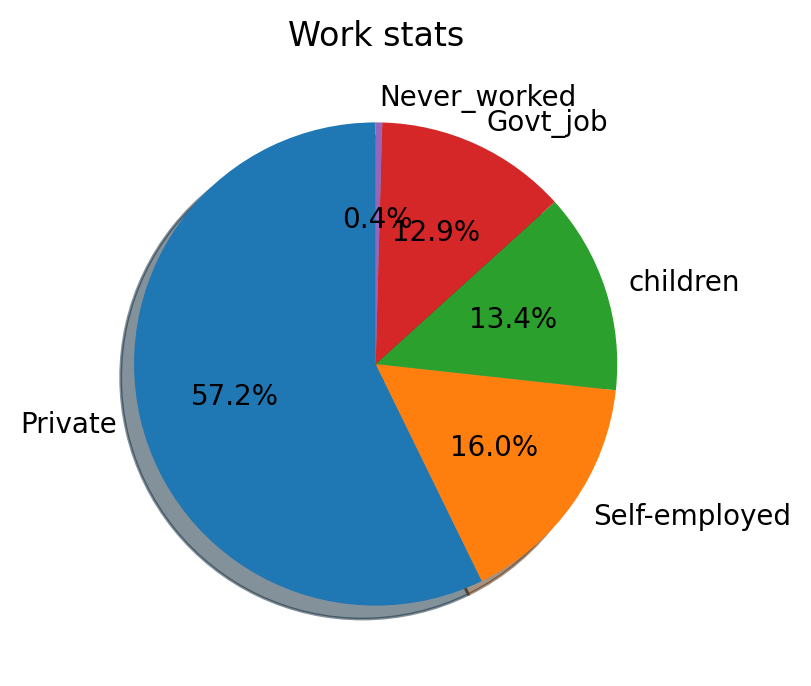

In [36]:
plot_single_stats('work_type', 'Work stats')
plt.rcParams['figure.dpi'] = 140

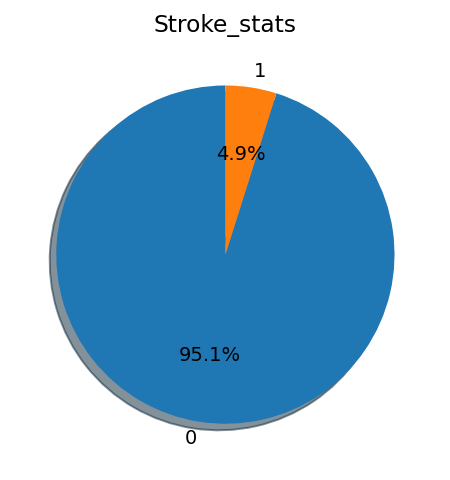

In [37]:
plot_single_stats('stroke', 'Stroke_stats')

In [7]:
def preproces_data(data_preprocess):
    data_copy = data_preprocess.copy()
    data_copy['ever_married'] = data_copy['ever_married'].map({'Yes': 1, 'No': 0})
    data_copy['work_type'] = data_copy['work_type'].map({'children': 0, 'Never_worked': 1, 'Self-employed': 2, 'Private': 3, 'Govt_job': 4})
    data_copy['smoking_status'] = data_copy['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': np.nan})
    reside_type_one_hot = pd.get_dummies(data_copy[['Residence_type']], drop_first=True)
    gender_one_hot = pd.get_dummies(data_copy[['gender']], drop_first=True)
    data_copy.drop(['Residence_type', 'gender'], axis=1, inplace=True)
    data_copy = data_copy.join(reside_type_one_hot)
    data_copy = data_copy.join(gender_one_hot)
    return data_copy

In [8]:
customised_data = preproces_data(data)
customised_data.head(10)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,Residence_type_Urban,gender_Male,gender_Other
0,67.0,0,1,1,3,228.69,36.6,1.0,1,1,1,0
1,61.0,0,0,1,2,202.21,NaN,0.0,1,0,0,0
2,80.0,0,1,1,3,105.92,32.5,0.0,1,0,1,0
3,49.0,0,0,1,3,171.23,34.4,2.0,1,1,0,0
4,79.0,1,0,1,2,174.12,24.0,0.0,1,0,0,0
5,81.0,0,0,1,3,186.21,29.0,1.0,1,1,1,0
6,74.0,1,1,1,3,70.09,27.4,0.0,1,0,1,0
7,69.0,0,0,0,3,94.39,22.8,0.0,1,1,0,0
8,59.0,0,0,1,3,76.15,NaN,NaN,1,0,0,0
9,78.0,0,0,1,3,58.57,24.2,NaN,1,1,0,0


<AxesSubplot:>

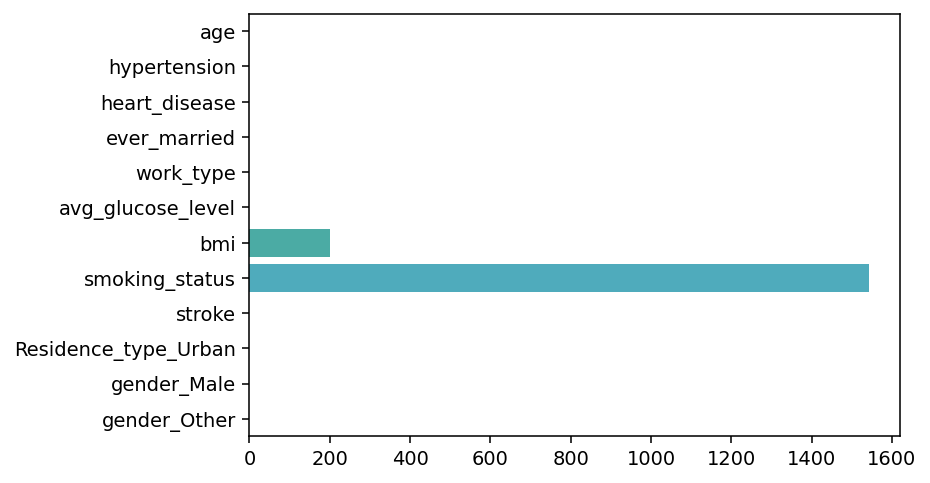

In [14]:
sums = customised_data.isnull().sum()
params = sums.index.tolist()
counts_nan = sums.values
sns.barplot(y=params, x=counts_nan)

In [15]:
bmi_regressor = DecisionTreeRegressor(random_state=42, max_depth=20)
smoking_status_regressor = DecisionTreeRegressor(random_state=42, max_depth=20)

In [16]:
data_bmi_none = customised_data[customised_data['bmi'].isna()]
data_bmi = customised_data[~customised_data['bmi'].isna()]
bmi_regressor.fit(data_bmi[['age', 'hypertension', 'heart_disease', 'ever_married', 
                           'work_type', 'gender_Male', 'gender_Other', 'Residence_type_Urban']], data_bmi['bmi'])
predicted_bmi = pd.Series(bmi_regressor.predict(data_bmi_none[['age', 'hypertension', 'heart_disease', 'ever_married', 
                           'work_type', 'gender_Male', 'gender_Other', 'Residence_type_Urban']]), index=data_bmi_none.index)
customised_data.loc[data_bmi_none.index, 'bmi'] = predicted_bmi

In [19]:
data_smoking_status_none = customised_data[customised_data['smoking_status'].isna()]
data_smoking_status = customised_data[~customised_data['smoking_status'].isna()]
smoking_status_regressor.fit(data_smoking_status[['age', 'hypertension', 'heart_disease', 'ever_married', 
                           'work_type', 'gender_Male', 'gender_Other', 'Residence_type_Urban', 'bmi']], data_smoking_status['smoking_status'])
predicted_smoking_status = pd.Series(smoking_status_regressor.predict(data_smoking_status_none[['age', 'hypertension', 'heart_disease', 'ever_married', 
                           'work_type', 'gender_Male', 'gender_Other', 'Residence_type_Urban', 'bmi']]), index=data_smoking_status_none.index)
customised_data.loc[data_smoking_status_none.index, 'smoking_status'] = predicted_smoking_status

In [32]:
columns = customised_data.columns.tolist()
columns.remove('stroke')
oversample = SMOTE()
X, y = oversample.fit_resample(customised_data[columns], 
                               customised_data['stroke'])
oversampled_data = X.assign(Stroke=y)

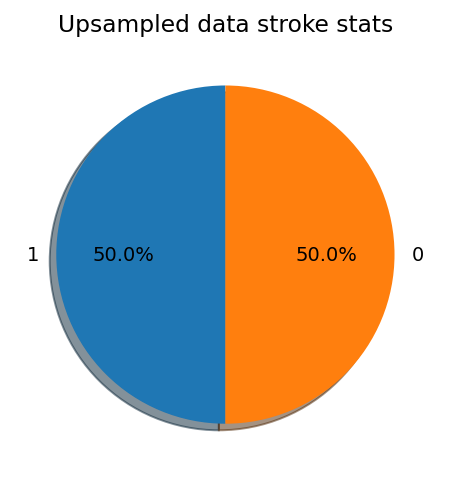

In [41]:
stroke_counts_afte_upsampling = oversampled_data['Stroke'].value_counts()

plt.pie(stroke_counts_afte_upsampling.values, labels=stroke_counts_afte_upsampling.index.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Upsampled data stroke stats")
plt.show()

In [50]:
oversampled_data.to_csv('oversampled_data.csv')
customised_data.to_csv('customised_data.csv')
print('Saved')

Saved


In [52]:
X_train, X_test, y_train, y_test = train_test_split(oversampled_data[columns], oversampled_data['Stroke'],
                                                   test_size=0.3, stratify=oversampled_data['Stroke'], 
                                                    random_state=42)

In [63]:
svc_classifier = Pipeline([
    ('scale', StandardScaler()),
    ('clf', SVC(gamma='auto'))
])

logistic_reg_etimator = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression())
])

models_params = {
    'svc': {
        'model': svc_classifier,
        'params': {
            'clf__C': [0.01, 0.1, 1, 10, 100],
            'clf__kernel': ['rbf', 'linear']
        }
    },
    'random_forest_classifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 5, 10, 15]
        }
    },
    'logistic_regressor': {
        'model': logistic_reg_etimator,
        'params': {
            'clf__C': [0.01, 0.1, 1, 10, 100]
        }
    }
}

In [64]:
scores = []

for model_name, mp in models_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svc,0.878178,"{'clf__C': 100, 'clf__kernel': 'rbf'}"
1,random_forest_classifier,0.933431,{'n_estimators': 15}
2,logistic_regressor,0.813373,{'clf__C': 0.1}


In [65]:
svc_model = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', C=100))
random_forest_model = RandomForestClassifier(n_estimators=15)
logistic_reg_model = make_pipeline(StandardScaler(), LogisticRegression(C=0.1))

In [67]:
svc_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
logistic_reg_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.1))])

In [68]:
y_svc_predicted = svc_model.predict(X_test)
y_random_forest_predicted = random_forest_model.predict(X_test)
y_logistic_reg_predicted = logistic_reg_model.predict(X_test)

In [98]:
svc_roc_auc = roc_auc_score(y_test, y_svc_predicted)
random_forest_roc_auc = roc_auc_score(y_test, y_random_forest_predicted)
logistic_reg_roc_auc = roc_auc_score(y_test, y_logistic_reg_predicted)

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_svc_predicted)
fpr_random_forest, tpr_random_forest, thresholds_random_forest = roc_curve(y_test, y_random_forest_predicted)
fpr_logistic_reg, tpr_logistic_reg, thresholds_logistic_reg = roc_curve(y_test, y_logistic_reg_predicted)

In [74]:
svc_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_svc_predicted)
random_forest_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_random_forest_predicted)
logistic_reg_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_logistic_reg_predicted)

In [92]:
def plot_confusion_matrics(matrix, title):
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         matrix.flatten()/np.sum(matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    plt.title(title)
    plt.show()

In [90]:
print('SVC f1-score: %.3f' % f1_score(y_true=y_test, y_pred=y_svc_predicted))
print('Random forest f1-score: %.3f' % f1_score(y_true=y_test, y_pred=y_random_forest_predicted))
print('Logistic regression f1-score: %.3f' % f1_score(y_true=y_test, y_pred=y_logistic_reg_predicted))

SVC f1-score: 0.897
Random forest f1-score: 0.941
Logistic regression f1-score: 0.818


In [84]:
plt.rcParams['figure.dpi'] = 100

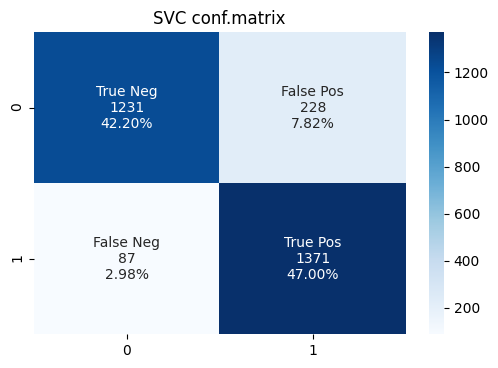

In [93]:
plot_confusion_matrics(svc_confusion_matrix, 'SVC conf.matrix')

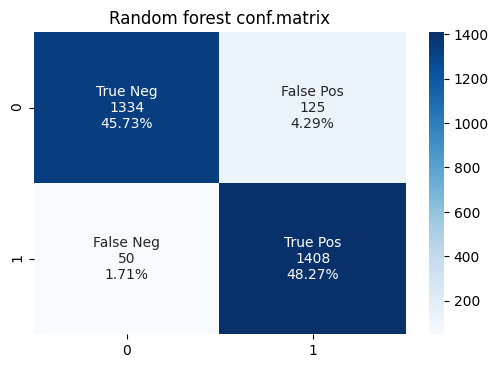

In [94]:
plot_confusion_matrics(random_forest_confusion_matrix, 'Random forest conf.matrix')

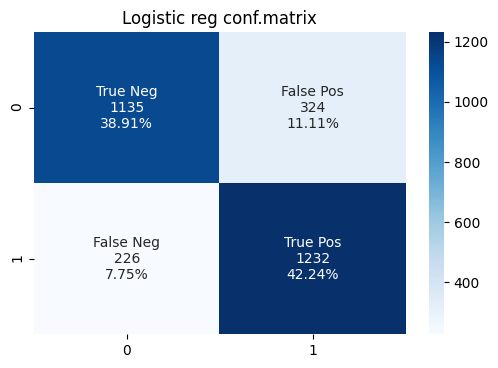

In [95]:
plot_confusion_matrics(logistic_reg_confusion_matrix, 'Logistic reg conf.matrix')

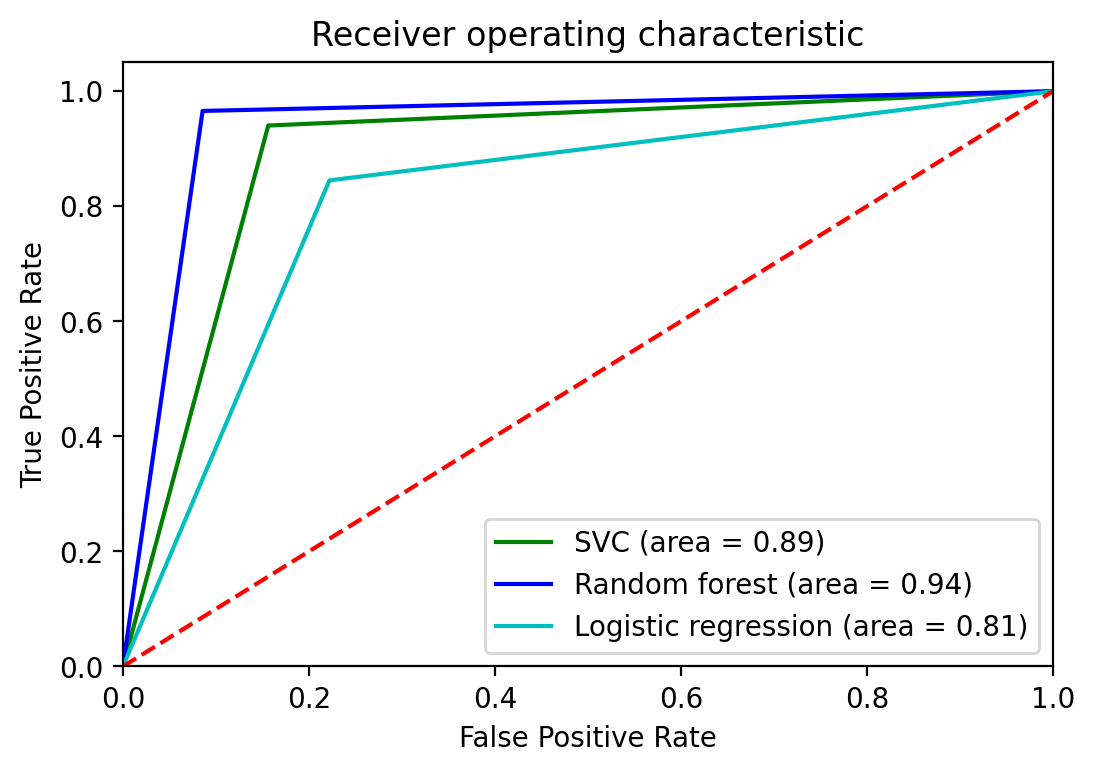

In [103]:
plt.rcParams['figure.dpi'] = 200

plt.figure()
plt.plot(fpr_svc, tpr_svc, label='SVC (area = %.2f)' % svc_roc_auc, color='g')
plt.plot(fpr_random_forest, tpr_random_forest, label='Random forest (area = %.2f)' % random_forest_roc_auc, color='b')
plt.plot(fpr_logistic_reg, tpr_logistic_reg, label='Logistic regression (area = %.2f)' % logistic_reg_roc_auc, color='c')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()